# PIB

## Packages

### Libraries

In [263]:
import sys
import os
import pandas as pd
import numpy as np
import time
import requests
from datetime import datetime
from dateutil.relativedelta import relativedelta


# For creating cool charts :)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.ticker as mtick
from matplotlib import image
import matplotlib as mpl
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.dates as mdates

# We load pre-defined functions, fonts and stylesheet.
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\utils")
    sys.path.append(module_path+"\\assets")

from tukan_helper_functions import *

path = [x for x in sys.path if "utils" in x][0]

# Optional for TUKAN's mplstylesheet
plt.style.use(module_path + '\\utils\\tukan_style.mpl')

In [264]:
import locale
locale.setlocale(locale.LC_ALL, 'es_es')

'es_es'

### Customized functions

In [265]:
# Filter dataframe by date range or for two specific dates
def date_selection(data_frame,first_date,last_date,inbewtween):
    if inbewtween==True:
        data_frame = data_frame[(data_frame["date"] >= first_date) & (data_frame["date"] <= last_date)].reset_index(drop = True)
    else:
        data_frame = data_frame[(data_frame["date"] == first_date) | (data_frame["date"] == last_date)].reset_index(drop = True)
    return(data_frame)

# Return last date for any dataframe with a 'date' columns
def last_date(dataframe):
    x= dataframe['date'].tail(1).dt.strftime('%Y-%m-%d').to_string()[-10:]
    return(x)

## (A) Overall

#### Payload

In [266]:
payload = {
    "type": "data_table",
    "operation": "sum",
    "language": "es",
    "group_by": [
        "economic_activity"
    ],
    "categories": {
        "economic_activity": [
            "dfeefc621d16d0c"
        ]
    },
    "request": [
        {
            "table": "mex_inegi_gdp_national",
            "variables": [
                "675882bced9ce54" #deflated
            ]
        }
    ],
    "from": "1999-01-01"
}

response = get_tukan_api_request(payload)
gdp = response["data"]
# gdp

Success getting the data


### Quarterly

#### Filter

In [267]:
# Data
filtered_gdp = gdp.copy()

# Units in millions
filtered_gdp['675882bced9ce54'] = filtered_gdp['675882bced9ce54']/1000000000

# Quarterly variation
filtered_gdp['qrtr_var'] = filtered_gdp.groupby(['economic_activity__ref'])['675882bced9ce54'].shift()
filtered_gdp['qrtr_var'] = (filtered_gdp['675882bced9ce54']/filtered_gdp['qrtr_var'])-1

# Yearly variation
filtered_gdp['year_var'] = filtered_gdp.groupby(['economic_activity__ref'])['675882bced9ce54'].shift(4)
filtered_gdp['year_var'] = (filtered_gdp['675882bced9ce54']/filtered_gdp['year_var'])-1

# Date filters
first_date = '2016-01-01'
second_date = last_date(filtered_gdp)
filtered_gdp = date_selection(filtered_gdp,first_date,second_date, True)

# Filtered data
filtered_gdp.tail(3)
# filtered_gdp

,date,economic_activity__ref,economic_activity,675882bced9ce54,qrtr_var,year_var
20,2021-01-01,dfeefc621d16d0c,Actividad económica,17377.786828,-0.035782,-0.037905
21,2021-04-01,dfeefc621d16d0c,Actividad económica,17995.091565,0.035523,0.198624
22,2021-07-01,dfeefc621d16d0c,Actividad económica,17567.080429,-0.023785,0.045345


#### Estimate

In [268]:
# Adding estimate
# eopib_qrtr_est = -0.001
# eopib_yrtr_est = 0.05

# gdp_estimate = {'date': datetime(2021, 10, 1), 'economic_activity__ref': 'dfeefc621d16d0c', 'economic_activity': 'Actividad económica', '675882bced9ce54':float(filtered_gdp['675882bced9ce54'].tail(1).values)*(1+eopib_qrtr_est),'qrtr_var':eopib_qrtr_est,'year_var':eopib_yrtr_est}

# filtered_gdp = filtered_gdp.append(gdp_estimate, ignore_index = True)
# filtered_gdp.tail(3)

#### YoY % Plot

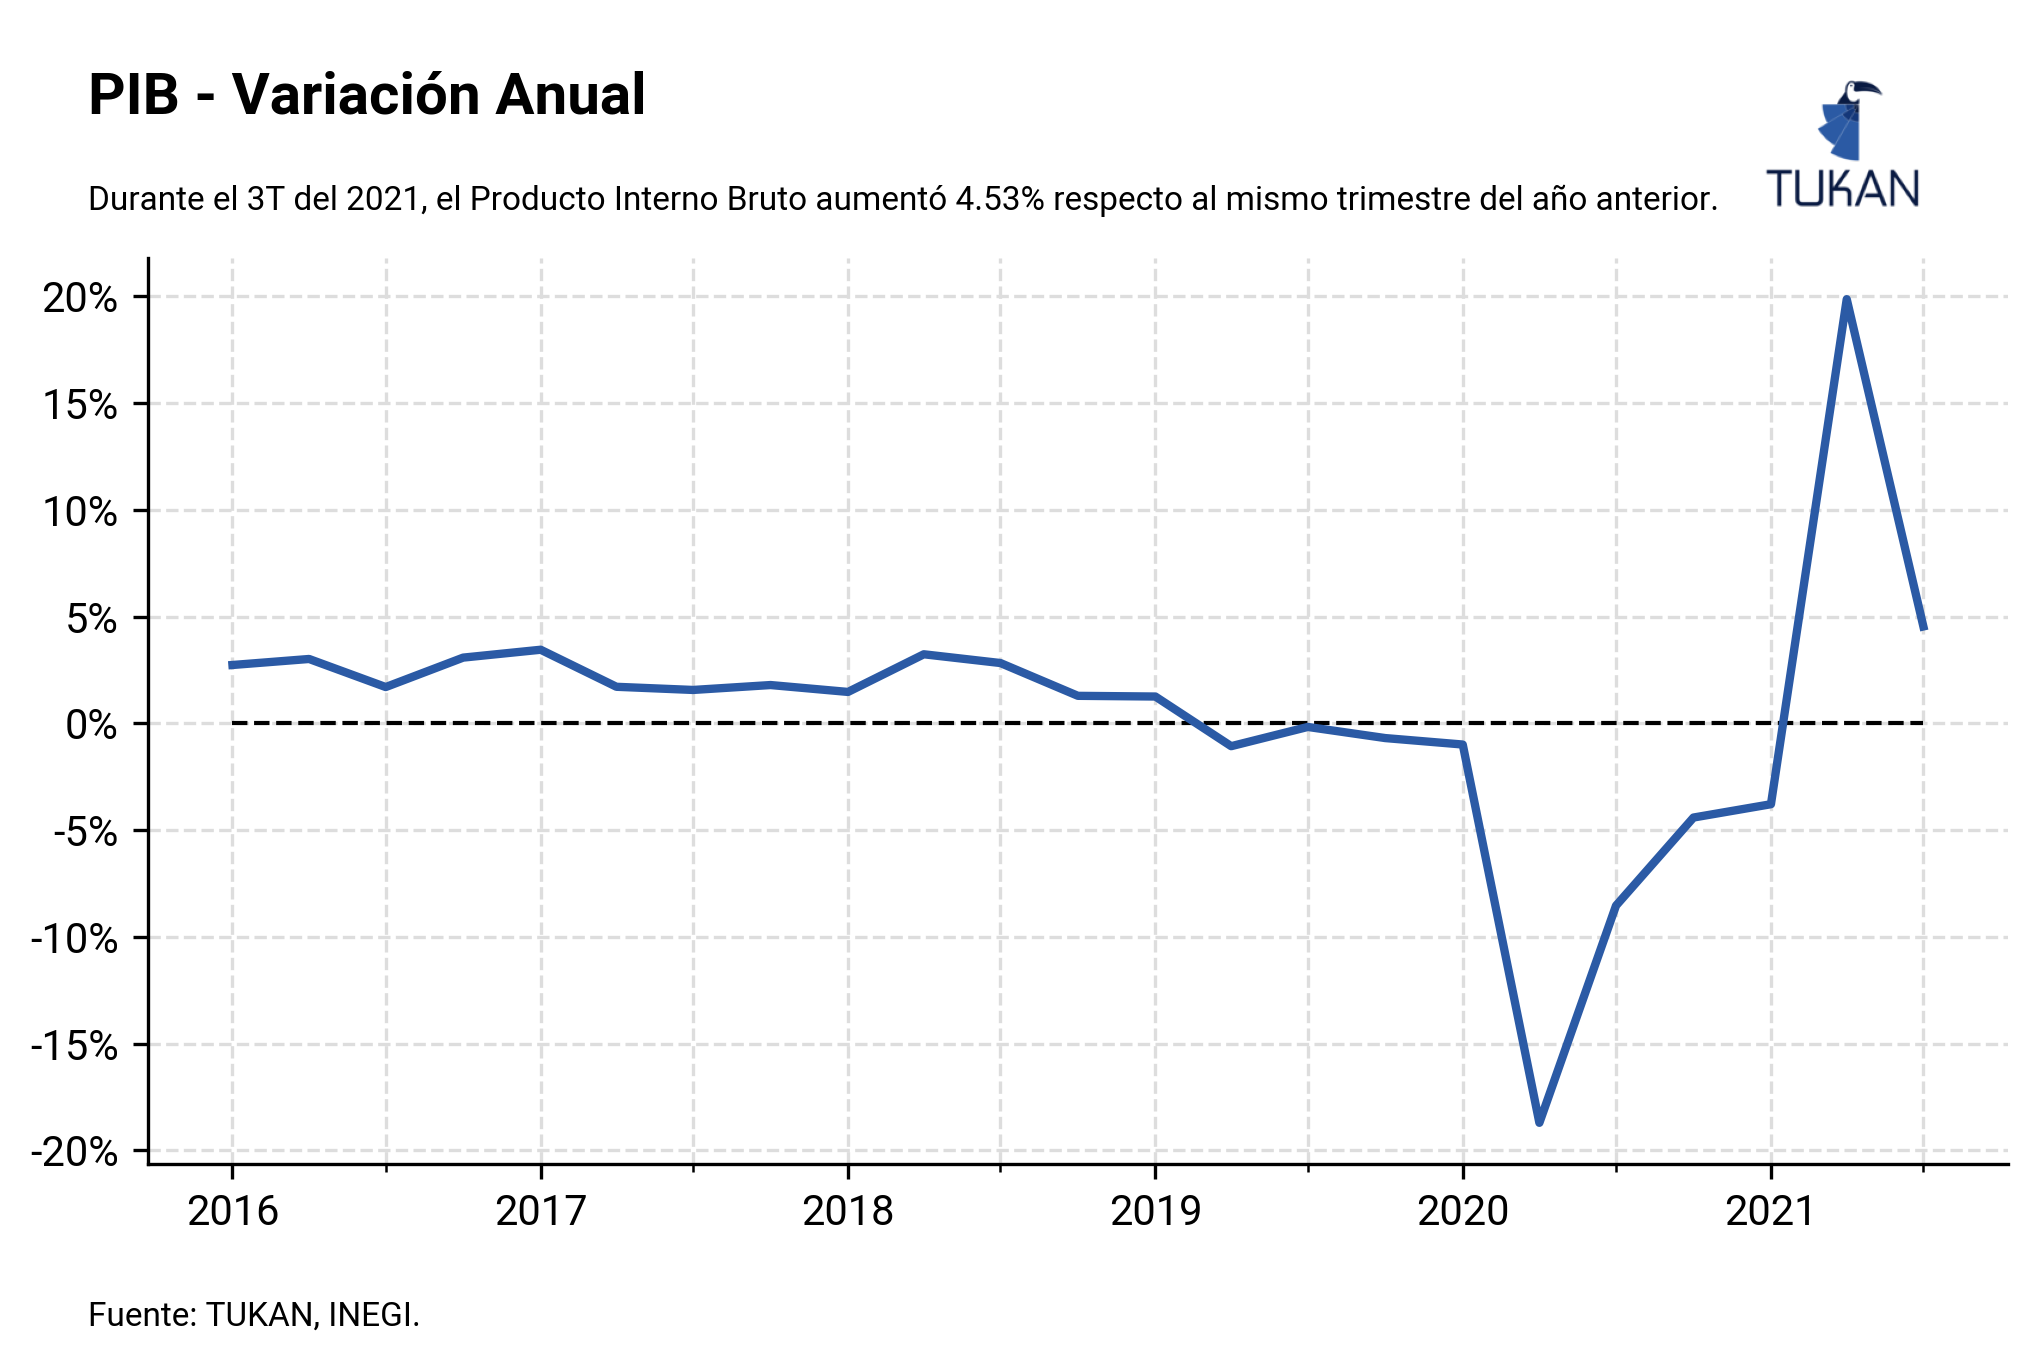

In [269]:
fig = plt.figure(dpi=300, figsize=(8,4))
ax = plt.subplot(111)

# Data to plot
ax.plot(filtered_gdp["date"], filtered_gdp["year_var"], lw=2, zorder=3)
ax.hlines(0, filtered_gdp["date"].min(), filtered_gdp["date"].max(), ls="--", color="black", lw=1)


# Add minor gridlines and format ticks
ax.xaxis.set_major_locator(mdates.MonthLocator(1))
ax.xaxis.set_minor_locator(mdates.MonthLocator(7))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y')) 

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0%}'))

ax.grid(visible=True, which='minor', linestyle='--')

# Title and subtitle aux vars
last_quarter = filtered_gdp["date"].tail(1).dt.quarter.values[0]
last_year = filtered_gdp["date"].tail(1).dt.year.values[0]
growth = filtered_gdp["year_var"].iloc[-1]*100

if growth>0:
    variation = 'aumentó'
else:
    variation = 'disminuyó'

fig.text(
    0.1,
    1,
    "PIB - Variación Anual",
    size=14,
    weight = "bold"
)
fig.text(
    0.1,
    0.92,
    "Durante el "+ str(last_quarter) + "T del "+str(last_year)+ ", el Producto Interno Bruto " + variation + " " + str(growth.round(2)) +"% respecto al mismo trimestre del año anterior.",
    size=8
)
# Add footer
fig.text(0.1, -0.01, "Fuente: TUKAN, INEGI.", fontsize=8)

# Save plot with TUKAN logo, transparent and white
# plt.savefig(
#     "plots/gdp_yoy_no_logo.png",
#     dpi=300,
#     bbox_inches="tight",
#     facecolor="white",
#     edgecolor="none",
#     transparent=True,
# )

tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([0.72, .88, 0.16, 0.19], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")

plt.savefig(
    "plots/gdp_yoy_logo.png",
    dpi=300,
    bbox_inches="tight",
    # facecolor="white",
    edgecolor="none",
    transparent=True,
)

plt.savefig(
    "plots/gdp_yoy_white_logo.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
    transparent=False,
)

#### QoQ % Plot

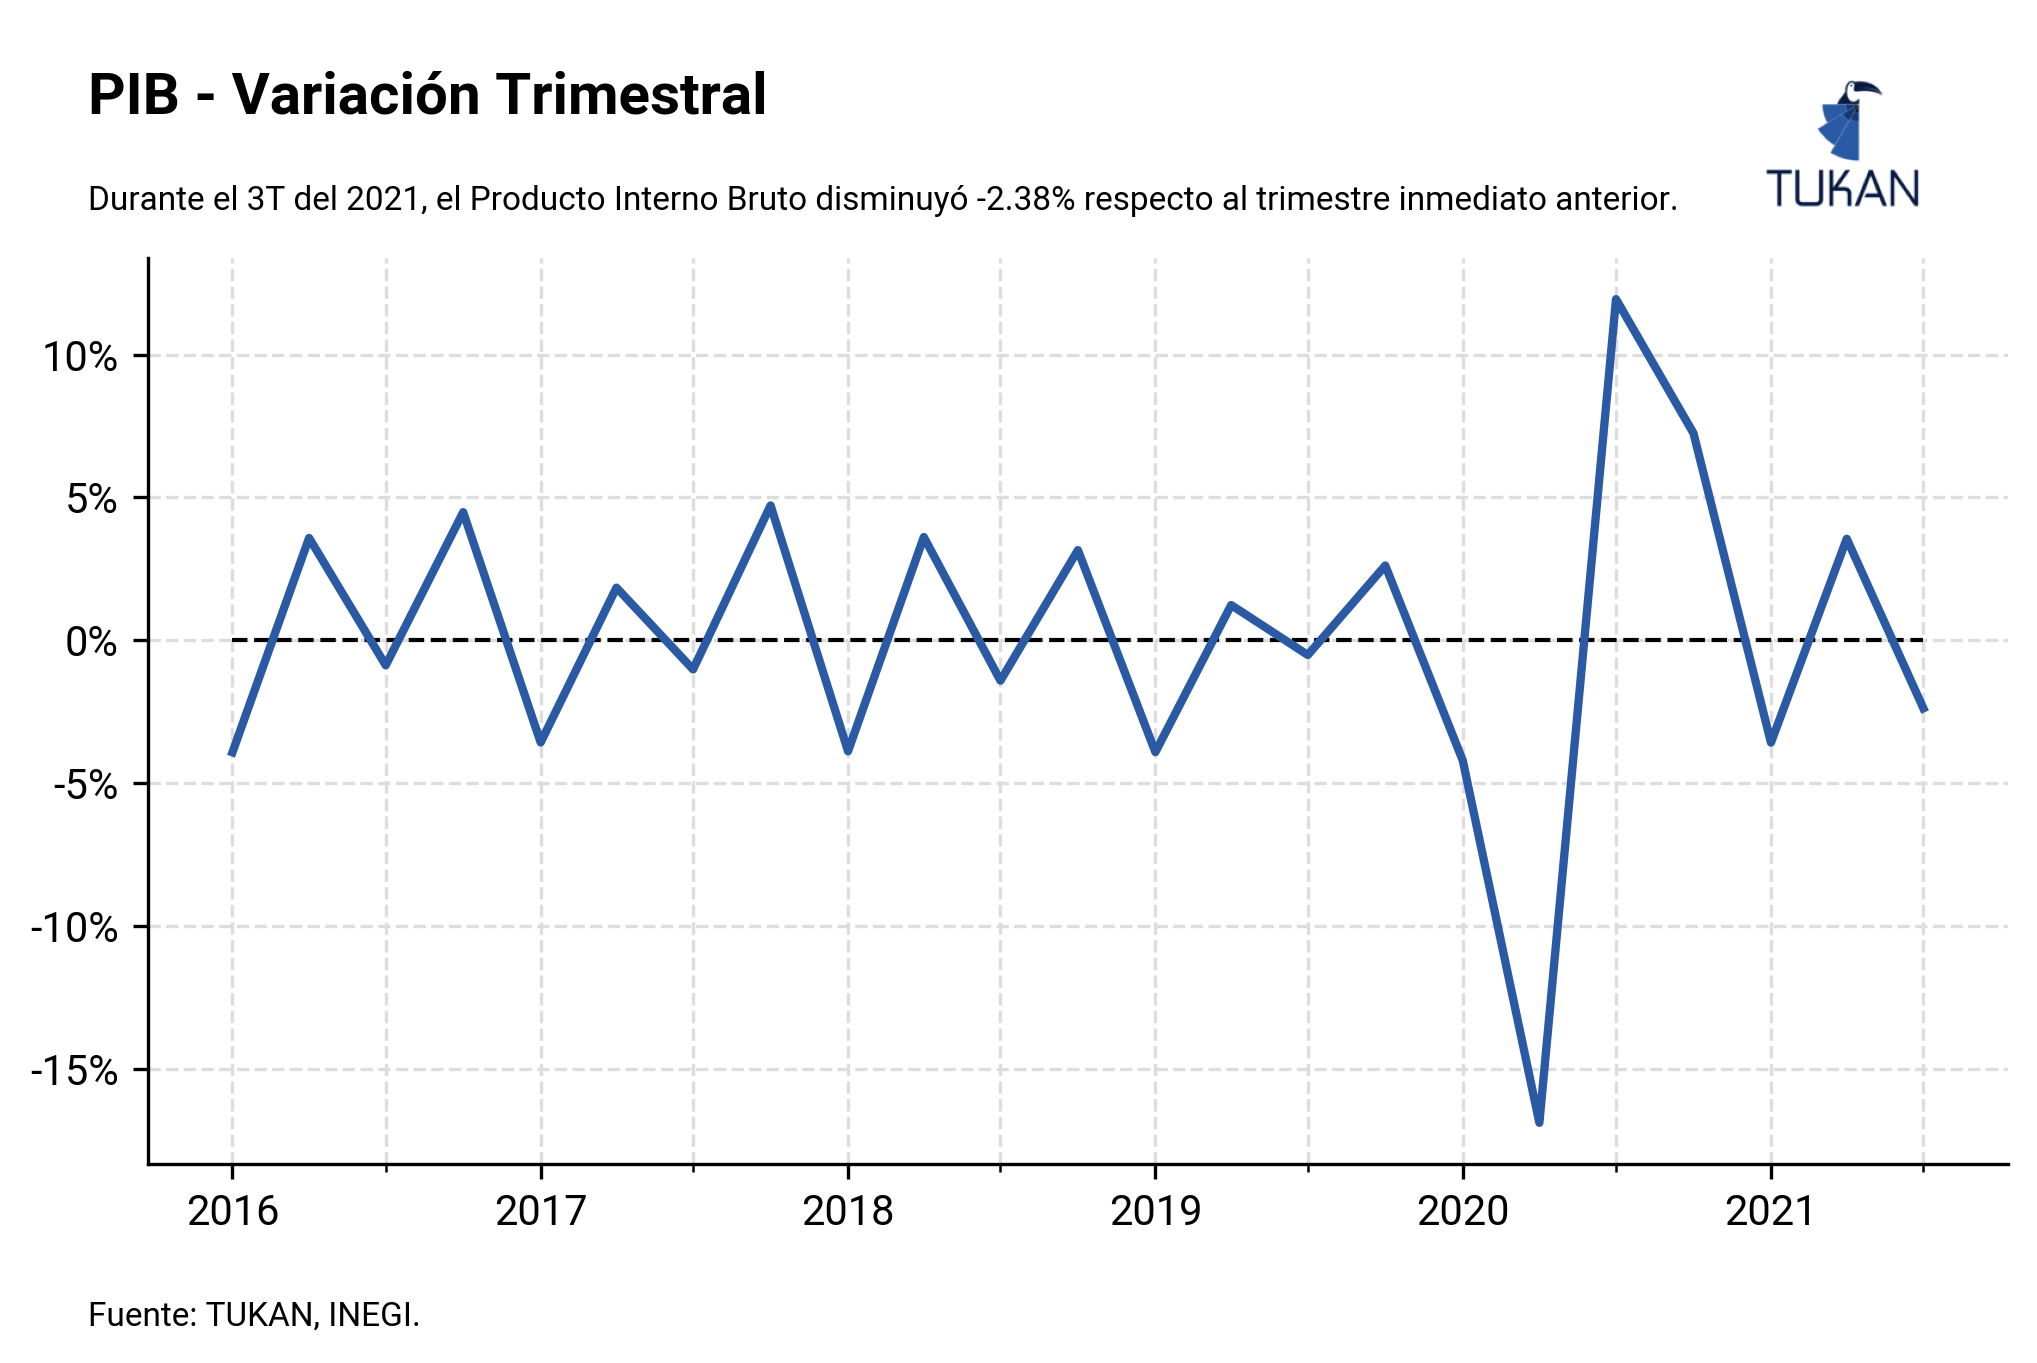

In [270]:
fig = plt.figure(dpi=300, figsize=(8,4))
ax = plt.subplot(111)

# Data to plot
ax.plot(filtered_gdp["date"], filtered_gdp["qrtr_var"], lw=2, zorder=3)
ax.hlines(0, filtered_gdp["date"].min(), filtered_gdp["date"].max(), ls="--", color="black", lw=1)

# Add minor gridlines and format ticks
ax.xaxis.set_major_locator(mdates.MonthLocator(1))
ax.xaxis.set_minor_locator(mdates.MonthLocator(7))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y')) 

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0%}'))

ax.grid(visible=True, which='minor', linestyle='--')

# Title and subtitle aux vars
last_quarter = filtered_gdp["date"].tail(1).dt.quarter.values[0]
last_year = filtered_gdp["date"].tail(1).dt.year.values[0]
growth = filtered_gdp["qrtr_var"].iloc[-1]*100

if growth>0:
    variation = 'aumentó'
else:
    variation = 'disminuyó'

fig.text(
    0.1,
    1,
    "PIB - Variación Trimestral",
    size=14,
    weight = "bold"
)
fig.text(
    0.1,
    0.92,
    "Durante el "+ str(last_quarter) + "T del "+str(last_year)+ ", el Producto Interno Bruto " + variation + " " + str(growth.round(2)) +"% respecto al trimestre inmediato anterior.",
    size=8
)
# Add footer
fig.text(0.1, -0.01, "Fuente: TUKAN, INEGI.", fontsize=8)

# Save plot with TUKAN logo, transparent and white
# plt.savefig(
#     "plots/gdp_qoq_no_logo.png",
#     dpi=300,
#     bbox_inches="tight",
#     facecolor="white",
#     edgecolor="none",
#     transparent=True,
# )

tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([0.72, .88, 0.16, 0.19], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")

plt.savefig(
    "plots/gdp_qoq_logo.png",
    dpi=300,
    bbox_inches="tight",
    # facecolor="white",
    edgecolor="none",
    transparent=True,
)

plt.savefig(
    "plots/gdp_qoq_white_logo.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
    transparent=False,
)

### Yearly

#### Filter

In [271]:
# Data
agg_filtered_gdp = gdp.copy()


# Units in billones (miles de millones)
agg_filtered_gdp['675882bced9ce54'] = agg_filtered_gdp['675882bced9ce54']/1000000000

# # Aggregated data
agg_filtered_gdp = agg_filtered_gdp.groupby([agg_filtered_gdp['date'].dt.year,'economic_activity__ref','economic_activity']).sum().reset_index()

# # Yearly variation
agg_filtered_gdp['year_var'] = agg_filtered_gdp.groupby(['economic_activity__ref'])['675882bced9ce54'].shift(1)
agg_filtered_gdp['year_var'] = (agg_filtered_gdp['675882bced9ce54']/agg_filtered_gdp['year_var'])-1

# # Date filters
# agg_filtered_gdp = agg_filtered_gdp[agg_filtered_gdp['date'] >=2000].reset_index(drop=True)
agg_filtered_gdp['date'] = pd.to_datetime(agg_filtered_gdp['date'].astype(str))


# # Filtered data
# agg_filtered_gdp.tail(5)
agg_filtered_gdp

,date,economic_activity__ref,economic_activity,675882bced9ce54,year_var
0,1999-01-01,dfeefc621d16d0c,Actividad económica,49295.288548,NaN
1,2000-01-01,dfeefc621d16d0c,Actividad económica,51731.685367,0.049425
2,2001-01-01,dfeefc621d16d0c,Actividad económica,51522.487540,-0.004044
3,2002-01-01,dfeefc621d16d0c,Actividad económica,51501.958672,-0.000398
4,2003-01-01,dfeefc621d16d0c,Actividad económica,52246.874084,0.014464
5,2004-01-01,dfeefc621d16d0c,Actividad económica,54295.260228,0.039206
6,2005-01-01,dfeefc621d16d0c,Actividad económica,55548.290080,0.023078
7,2006-01-01,dfeefc621d16d0c,Actividad económica,58045.228987,0.044951
8,2007-01-01,dfeefc621d16d0c,Actividad económica,59375.303901,0.022914
9,2008-01-01,dfeefc621d16d0c,Actividad económica,60054.310724,0.011436


#### Estimate

In [272]:
# Adding estimate
# eopib_yrtr_est = 0.05

# gdp_estimate = {'date':datetime(2022, 1, 1), 'economic_activity__ref': 'dfeefc621d16d0c', 'economic_activity': 'Actividad económica', '675882bced9ce54':float(agg_filtered_gdp['675882bced9ce54'].tail(1).values)*(1+eopib_yrtr_est),'year_var':eopib_yrtr_est}

# agg_filtered_gdp = agg_filtered_gdp.append(gdp_estimate, ignore_index = True)
# agg_filtered_gdp.tail(3)

#### Aggregate Plot


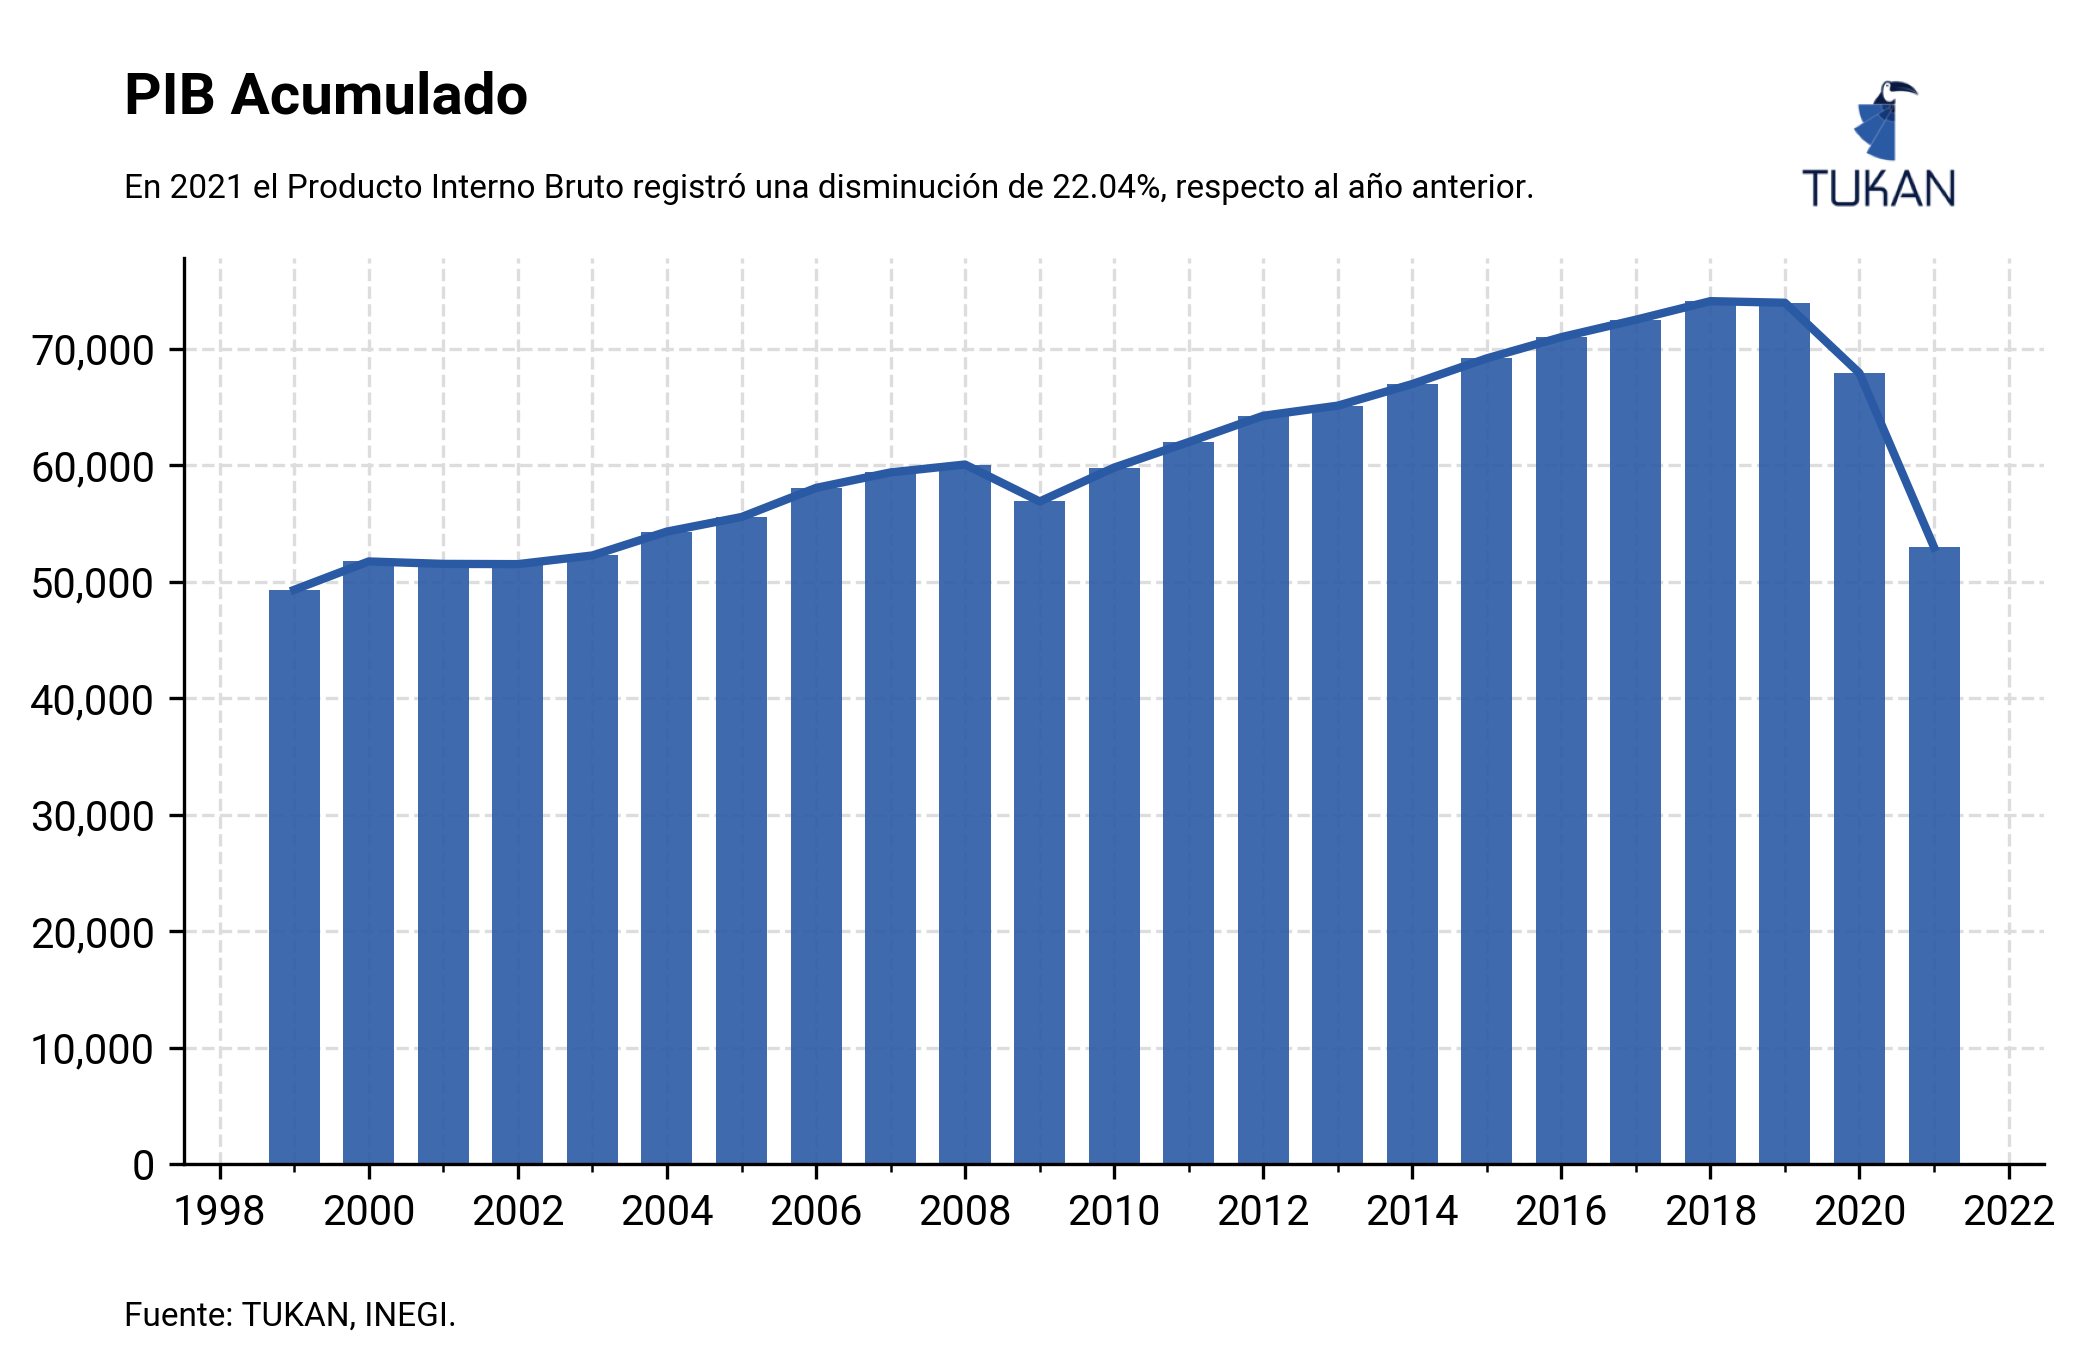

In [273]:
fig = plt.figure(dpi=300, figsize=(8,4))
ax = plt.subplot(111)

# Data to plot
ax.plot(agg_filtered_gdp["date"], agg_filtered_gdp["675882bced9ce54"], lw=2, zorder=3)
ax.bar(agg_filtered_gdp["date"], agg_filtered_gdp["675882bced9ce54"], zorder=2, width = 250, align='center', alpha=0.9)

# Add minor gridlines and format ticks
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_formatter(" ") 

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

ax.grid(visible=True, which='minor', linestyle='--')

ax.set_ylim(0)
# Title and subtitle aux vars
last_year = agg_filtered_gdp["date"].tail(1).dt.year.values[0]
growth = agg_filtered_gdp["year_var"].iloc[-1]*100

if growth>0:
    variation = 'un crecimiento'
else:
    variation = 'una disminución'

fig.text(
    0.1,
    1,
    "PIB Acumulado",
    size=14,
    weight = "bold"
)
fig.text(
    0.1,
    0.93,
    "En "+ str(last_year) + " el Producto Interno Bruto registró "+ variation + " de " + str(abs(growth.round(2))) +"%, respecto al año anterior.",
    size=8
)
# Add footer
fig.text(0.1, -0.01, "Fuente: TUKAN, INEGI.", fontsize=8)

# Save plot with TUKAN logo, transparent and white
# plt.savefig(
#     "plots/gdp_agg_no_logo.png",
#     dpi=300,
#     bbox_inches="tight",
#     # facecolor="white",
#     edgecolor="none",
#     transparent=True,
# )

tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([0.72, .88, 0.16, 0.19], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")

plt.savefig(
    "plots/gdp_agg_logo.png",
    dpi=300,
    bbox_inches="tight",
    # facecolor="white",
    edgecolor="none",
    transparent=True,
)

plt.savefig(
    "plots/gdp_agg_white_logo.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
    transparent=False,
)

#### YoY % plot


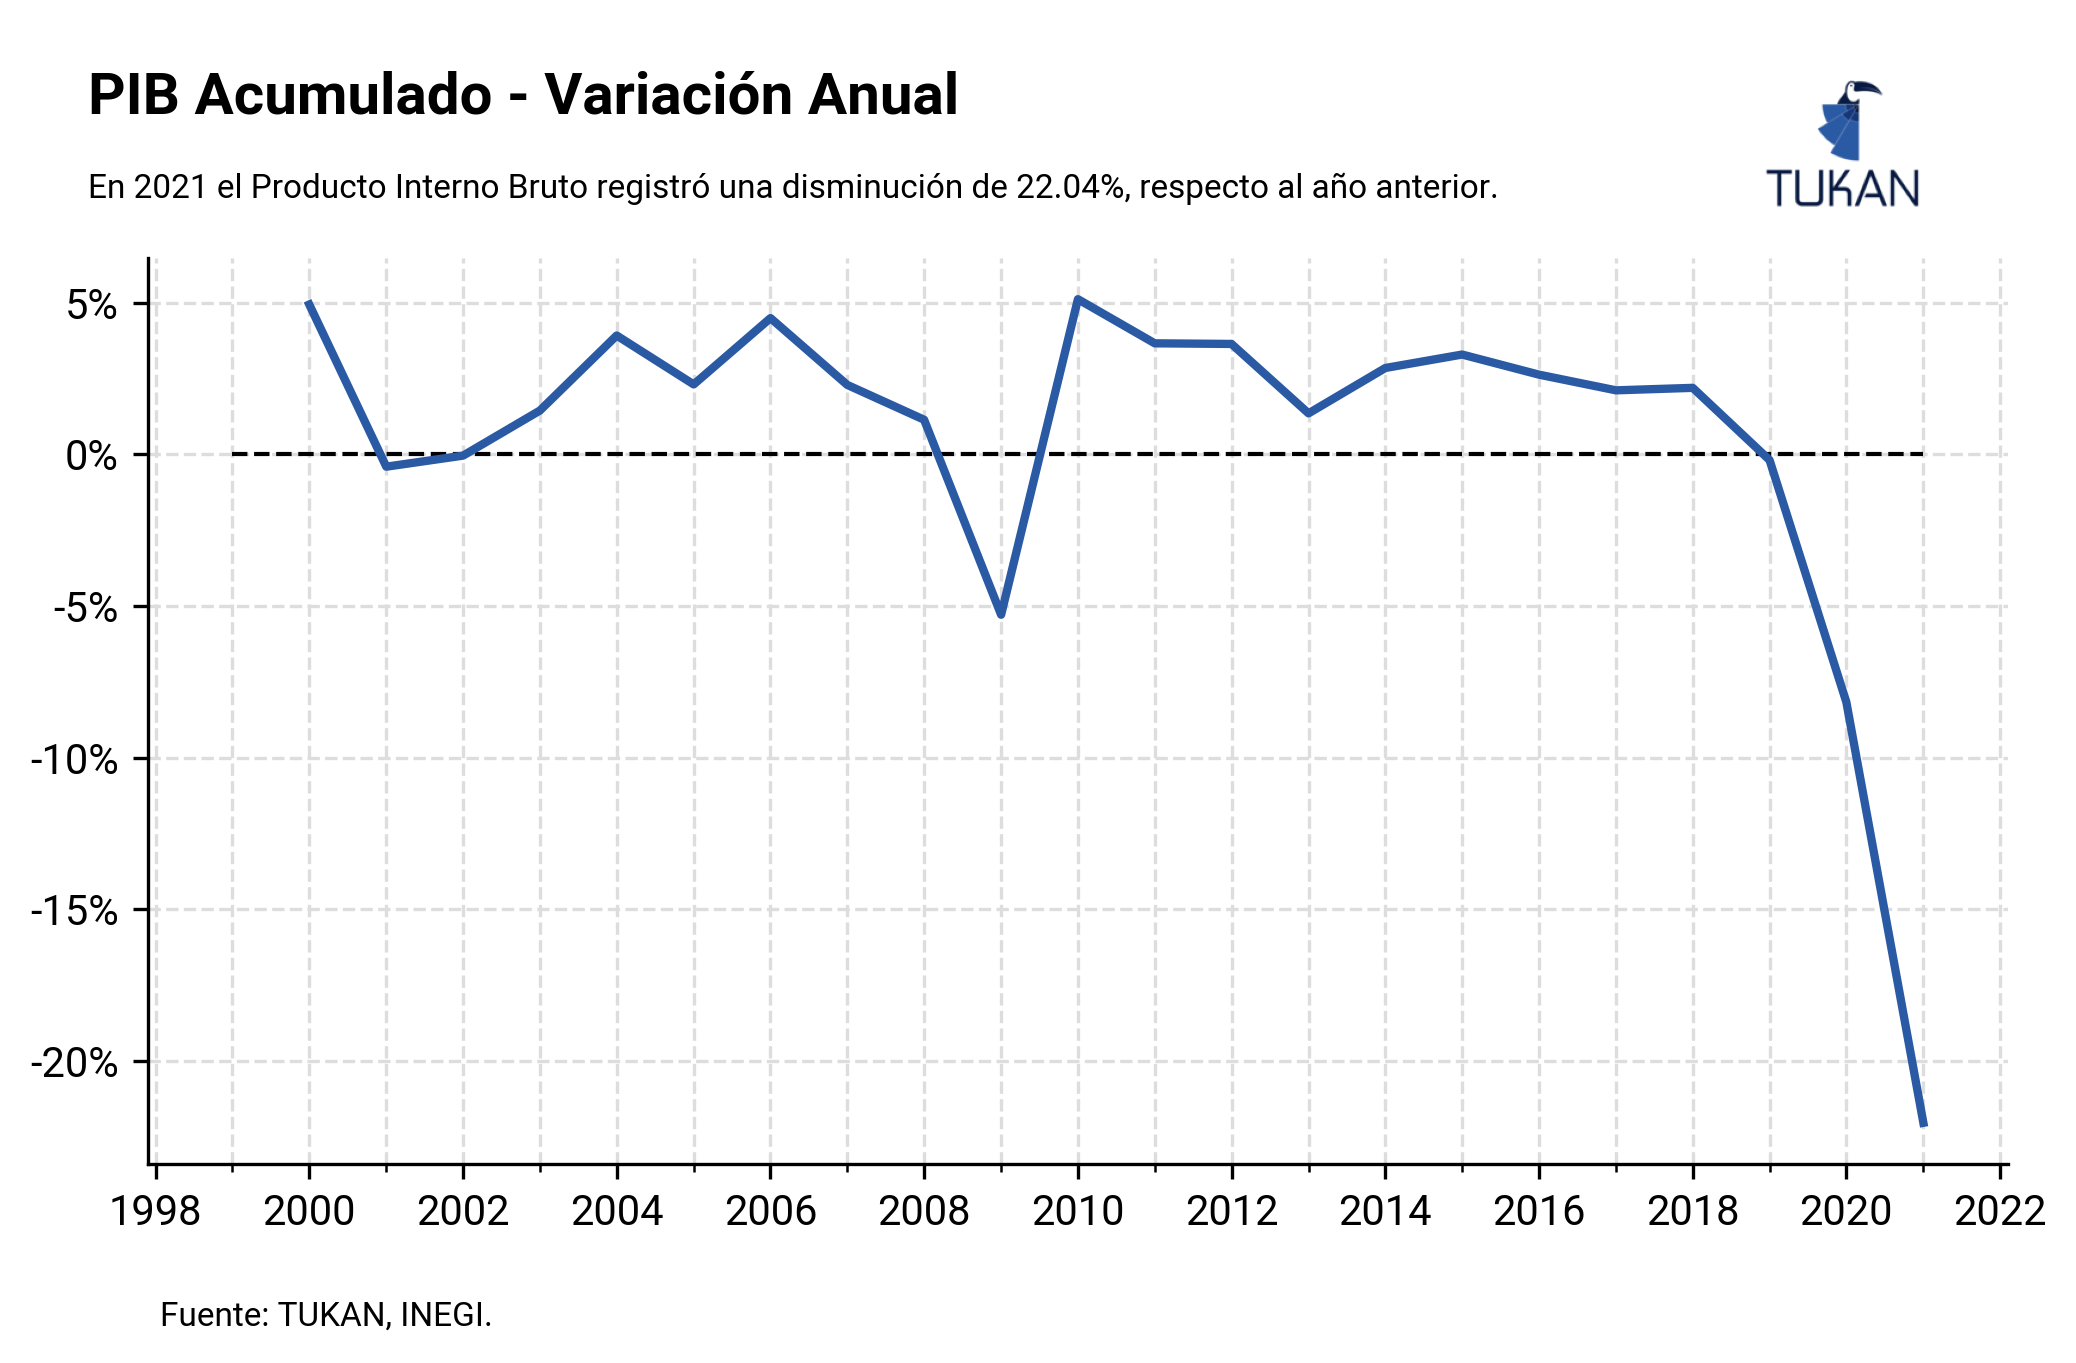

In [288]:
fig = plt.figure(dpi=300, figsize=(8,4))
ax = plt.subplot(111)

# Data to plot
ax.plot(agg_filtered_gdp["date"], agg_filtered_gdp["year_var"], lw=2, zorder=3)
ax.hlines(0, agg_filtered_gdp["date"].min(), agg_filtered_gdp["date"].max(), ls="--", color="black", lw=1)
# ax.bar(agg_filtered_gdp["date"], agg_filtered_gdp["year_var"], zorder=2, width = 250, align='center', alpha=0.9)

# Add minor gridlines and format ticks
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_formatter(" ") 

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0%}'))

ax.grid(visible=True, which='minor', linestyle='--')


# Title and subtitle aux vars
last_year = agg_filtered_gdp["date"].tail(1).dt.year.values[0]
growth = agg_filtered_gdp["year_var"].iloc[-1]*100

if growth>0:
    variation = 'un crecimiento'
else:
    variation = 'una disminución'

fig.text(
    0.1,
    1,
    "PIB Acumulado - Variación Anual",
    size=14,
    weight = "bold"
)
fig.text(
    0.1,
    0.93,
    "En "+ str(last_year) + " el Producto Interno Bruto registró "+ variation + " de " + str(abs(growth.round(2))) +"%, respecto al año anterior.",
    size=8
)
# Add footer
fig.text(0.13, -0.01, "Fuente: TUKAN, INEGI.", fontsize=8)

# Save plot with TUKAN logo, transparent and white
# plt.savefig(
#     "plots/gdp_agg_yoy_no_logo.png",
#     dpi=300,
#     bbox_inches="tight",
#     # facecolor="white",
#     edgecolor="none",
#     transparent=True,
# )

tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([0.72, .88, 0.16, 0.19], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")

plt.savefig(
    "plots/gdp_agg_yoy_logo.png",
    dpi=300,
    bbox_inches="tight",
    # facecolor="white",
    edgecolor="none",
    transparent=True,
)

plt.savefig(
    "plots/gdp_agg_yoy_white_logo.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
    transparent=False,
)

## (B) Economic Sectors

### Primary

#### Payload

In [275]:
payload = {
    "type": "data_table",
    "operation": "sum",
    "language": "es",
    "group_by": [
        "economic_activity"
    ],
    "categories": {
        "economic_activity": [
            "7460634ca523beb"
        ]
    },
    "request": [
        {
            "table": "mex_inegi_gdp_national",
            "variables": [
                "675882bced9ce54" #deflated
            ]
        }
    ],
    "from": "2001-01-01"
}

response = get_tukan_api_request(payload)
gdp_primary = response["data"]

Success getting the data


#### Filtering data

In [276]:
# Data
filtered_gdp_primary = gdp_primary.copy()

# Units in millions
filtered_gdp_primary['675882bced9ce54'] = filtered_gdp_primary['675882bced9ce54']/1000000

# Quarterly variation
filtered_gdp_primary['qrtr_var'] = filtered_gdp_primary.groupby(['economic_activity__ref'])['675882bced9ce54'].shift()
filtered_gdp_primary['qrtr_var'] = (filtered_gdp_primary['675882bced9ce54']/filtered_gdp_primary['qrtr_var'])-1

# Yearly variation
filtered_gdp_primary['year_var'] = filtered_gdp_primary.groupby(['economic_activity__ref'])['675882bced9ce54'].shift(4)
filtered_gdp_primary['year_var'] = (filtered_gdp_primary['675882bced9ce54']/filtered_gdp_primary['year_var'])-1

# Date filters
first_date = '2021-01-01'
second_date = last_date(filtered_gdp_primary)
filtered_gdp_primary = date_selection(filtered_gdp_primary,first_date,second_date, True)

# Filtered data
filtered_gdp_primary.tail(3)

,date,economic_activity__ref,economic_activity,675882bced9ce54,qrtr_var,year_var
0,2021-01-01,7460634ca523beb,Actividades primarias,562997.803,-0.197645,-0.009624
1,2021-04-01,7460634ca523beb,Actividades primarias,626953.575,0.113599,0.063620
2,2021-07-01,7460634ca523beb,Actividades primarias,520266.396,-0.170168,0.006403


#### Estimate

In [277]:
# Adding estimate
# eopib_qrtr_est = 0.003
# eopib_yrtr_est = .027

# gdp_estimate = {'date': datetime(2021, 10, 1), 'economic_activity__ref': '7460634ca523beb', 'economic_activity': 'Actividades primarias', '675882bced9ce54':float(filtered_gdp_primary['675882bced9ce54'].tail(1).values)*(1+eopib_qrtr_est),'qrtr_var':eopib_qrtr_est,'year_var':eopib_yrtr_est}

# filtered_gdp_primary = filtered_gdp_primary.append(gdp_estimate, ignore_index = True)
# filtered_gdp_primary.tail(3)

### Secondary

#### Payload

In [278]:
payload = {
    "type": "data_table",
    "operation": "sum",
    "language": "es",
    "group_by": [
        "economic_activity"
    ],
    "categories": {
        "economic_activity": [
            "761bc00426e1c48"
        ]
    },
    "request": [
        {
            "table": "mex_inegi_gdp_national",
            "variables": [
                "675882bced9ce54" #deflated
            ]
        }
    ],
    "from": "2001-01-01"
}

response = get_tukan_api_request(payload)
gdp_secondary = response["data"]

Success getting the data


#### Filtering data

In [279]:
# Data
filtered_gdp_secondary = gdp_secondary.copy()

# Units in millions
filtered_gdp_secondary['675882bced9ce54'] = filtered_gdp_secondary['675882bced9ce54']/1000000

# Quarterly variation
filtered_gdp_secondary['qrtr_var'] = filtered_gdp_secondary.groupby(['economic_activity__ref'])['675882bced9ce54'].shift()
filtered_gdp_secondary['qrtr_var'] = (filtered_gdp_secondary['675882bced9ce54']/filtered_gdp_secondary['qrtr_var'])-1

# Yearly variation
filtered_gdp_secondary['year_var'] = filtered_gdp_secondary.groupby(['economic_activity__ref'])['675882bced9ce54'].shift(4)
filtered_gdp_secondary['year_var'] = (filtered_gdp_secondary['675882bced9ce54']/filtered_gdp_secondary['year_var'])-1

# Date filters
first_date = '2021-01-01'
second_date = last_date(filtered_gdp_secondary)
filtered_gdp_secondary = date_selection(filtered_gdp_secondary,first_date,second_date, True)

# Filtered data
filtered_gdp_secondary.tail(3)

,date,economic_activity__ref,economic_activity,675882bced9ce54,qrtr_var,year_var
0,2021-01-01,761bc00426e1c48,Actividades secundarias,5072005.434,0.010528,-0.033039
1,2021-04-01,761bc00426e1c48,Actividades secundarias,5087924.014,0.003139,0.274824
2,2021-07-01,761bc00426e1c48,Actividades secundarias,5135017.076,0.009256,0.049774


#### Estimate

In [280]:
# Adding estimate
# eopib_qrtr_est = 0.004
# eopib_yrtr_est = 0.068

# gdp_estimate = {'date': datetime(2021, 10, 1), 'economic_activity__ref': '7460634ca523beb', 'economic_activity': 'Actividades secundarias', '675882bced9ce54':float(filtered_gdp_secondary['675882bced9ce54'].tail(1).values)*(1+eopib_qrtr_est),'qrtr_var':eopib_qrtr_est,'year_var':eopib_yrtr_est}

# filtered_gdp_secondary = filtered_gdp_secondary.append(gdp_estimate, ignore_index = True)
# filtered_gdp_secondary['qrtr_var'] =filtered_gdp_secondary['qrtr_var']*100
# filtered_gdp_secondary.tail(3)

### Terciary

#### Payload

In [281]:
payload = {
    "type": "data_table",
    "operation": "sum",
    "language": "es",
    "group_by": [
        "economic_activity"
    ],
    "categories": {
        "economic_activity": [
            "8fd5b02b9f891fb"
        ]
    },
    "request": [
        {
            "table": "mex_inegi_gdp_national",
            "variables": [
                "675882bced9ce54" #deflated
            ]
        }
    ],
    "from": "2001-01-01"
}

response = get_tukan_api_request(payload)
gdp_terciary = response["data"]

Success getting the data


#### Filtering data

In [282]:
# Data
filtered_gdp_terciary = gdp_terciary.copy()

# Units in millions
filtered_gdp_terciary['675882bced9ce54'] = filtered_gdp_terciary['675882bced9ce54']/1000000

# Quarterly variation
filtered_gdp_terciary['qrtr_var'] = filtered_gdp_terciary.groupby(['economic_activity__ref'])['675882bced9ce54'].shift()
filtered_gdp_terciary['qrtr_var'] = (filtered_gdp_terciary['675882bced9ce54']/filtered_gdp_terciary['qrtr_var'])-1

# Yearly variation
filtered_gdp_terciary['year_var'] = filtered_gdp_terciary.groupby(['economic_activity__ref'])['675882bced9ce54'].shift(4)
filtered_gdp_terciary['year_var'] = (filtered_gdp_terciary['675882bced9ce54']/filtered_gdp_terciary['year_var'])-1

# Date filters
first_date = '2021-01-01'
second_date = last_date(filtered_gdp_terciary)
filtered_gdp_terciary = date_selection(filtered_gdp_terciary,first_date,second_date, True)

# Filtered data
filtered_gdp_terciary.tail(3)

,date,economic_activity__ref,economic_activity,675882bced9ce54,qrtr_var,year_var
0,2021-01-01,8fd5b02b9f891fb,Actividades terciarias,1.104206e+07,-0.043640,-0.038391
1,2021-04-01,8fd5b02b9f891fb,Actividades terciarias,1.154939e+07,0.045945,0.176513
2,2021-07-01,8fd5b02b9f891fb,Actividades terciarias,1.114744e+07,-0.034802,0.042114


#### Estimate

In [283]:
# Adding estimate
# eopib_qrtr_est = -0.007
# eopib_yrtr_est = 0.042

# gdp_estimate = {'date': datetime(2021, 10, 1), 'economic_activity__ref': '8fd5b02b9f891fb', 'economic_activity': 'Actividades terciarias', '675882bced9ce54':float(filtered_gdp_terciary['675882bced9ce54'].tail(1).values)*(1+eopib_qrtr_est),'qrtr_var':eopib_qrtr_est,'year_var':eopib_yrtr_est}

# filtered_gdp_terciary = filtered_gdp_terciary.append(gdp_estimate, ignore_index = True)
# filtered_gdp_terciary.tail(3)

## (C) Ecnonomic Activities

### Payload

In [284]:
# Main payload
payload = {
    "type": "data_table",
    "operation": "sum",
    "language": "es",
    "group_by": [
        "economic_activity"
    ],
    "categories": {
        "economic_activity": [
            "6b36ca46b6cfd91",
            "457155464609a2f",
            "36348912d8470dd",
            "faa2a8d0af8a72c",
            "be676b5dd921cb7",
            "f5adaadda584ca7",
            "e426cc87d0540ab",
            "afcc312ccddfcc1",
            "990b94ebe38c9ca",
            "d35f5b82779e7d5",
            "3726993cc9fecab",
            "bbb49ae78601ab9",
            "4bc9836c2d7e60a",
            "fcb303b72a98f6c",
            "d05c3b2b73d75fc",
            "44d246411040129",
            "a07267f78158c2c",
            "feb7bb4445c808d",
            "169c33ccdd66d77",
            "23cf92d98dd7c11"
        ]
    },
    "request": [
        {
            "table": "mex_inegi_gdp_national",
            "variables": [
                "675882bced9ce54"
            ]
        }
    ],
    "from": "2000-01-01"
}

response = get_tukan_api_request(payload)

Success getting the data


### Cumulative GDP

In [285]:
# Data
activities_gdp = response["data"]

# Remove the quarters from previous years that are not available yet for the current year
date_filter = activities_gdp['date'].max().month
activities_gdp = activities_gdp[activities_gdp["date"].dt.month<= date_filter]

# Calculate the cumulative GDP for each year and economic activity, dividing it by a million 
activities_gdp = activities_gdp.groupby([activities_gdp.date.dt.year,'economic_activity__ref','economic_activity']).sum().reset_index()
activities_gdp['675882bced9ce54'] = activities_gdp['675882bced9ce54']/1000000

# Pivot the data frame so it is easy to plot, calculate the variation between 2021-2019 and 2021-2020, sort ascendingly according to it
activities_gdp = activities_gdp.pivot(index = 'economic_activity', columns='date', values='675882bced9ce54').reset_index()
activities_gdp['var_2021_2019'] =  (activities_gdp[2021] / activities_gdp[2019])-1
activities_gdp['var_2021_2020'] =  (activities_gdp[2021] / activities_gdp[2020])-1
activities_gdp['var_2020_2019'] =  (activities_gdp[2020] / activities_gdp[2019])-1

# Rename the tickers to improve plot design
activities_gdp = activities_gdp.replace({'Servicios de esparcimiento culturales y deportivos, y otros servicios recreativos':'Serv. de esparcimiento y recreativos',
                   'Generación, transmisión, distribución y comercialización de energía eléctrica, suministro de agua y de gas natural por ductos al consumidor final':'Energía, suministro de agua y gas natural',
                   'Servicios de alojamiento temporal y de preparación de alimentos y bebidas':'Hoteles y Restaurantes',
                   'Otros servicios excepto actividades gubernamentales':'Otros servicios',
                   'Agricultura, cría y explotación de animales, aprovechamiento forestal, pesca y caza':'Agricultura, ganadería, pesca y acts. forestales',
                   'Servicios de apoyo a los negocios y manejo de residuos, y servicios de remediación':'Serv. de apoyo a los negocios y manejo de residuos',
                   'Actividades legislativas, gubernamentales, de impartición de justicia y de organismos internacionales y extraterritoriales':'Acts. gubernamentales y legislativas',
                   'Servicios inmobiliarios y de alquiler de bienes muebles e intangibles':'Serv. inmobiliarios y alquiler de bienes',
                   'Servicios de salud y de asistencia social':'Serv. sociales y de salud',
                   'Servicios profesionales, científicos y técnicos':'Serv. profesionales, científicos y técnicos',
                   'Servicios educativos':'Serv. educativos',
                   'Servicios financieros y de seguros':
                   'Serv. financieros y de seguros'
 })

### 2021 vs 2020 plot

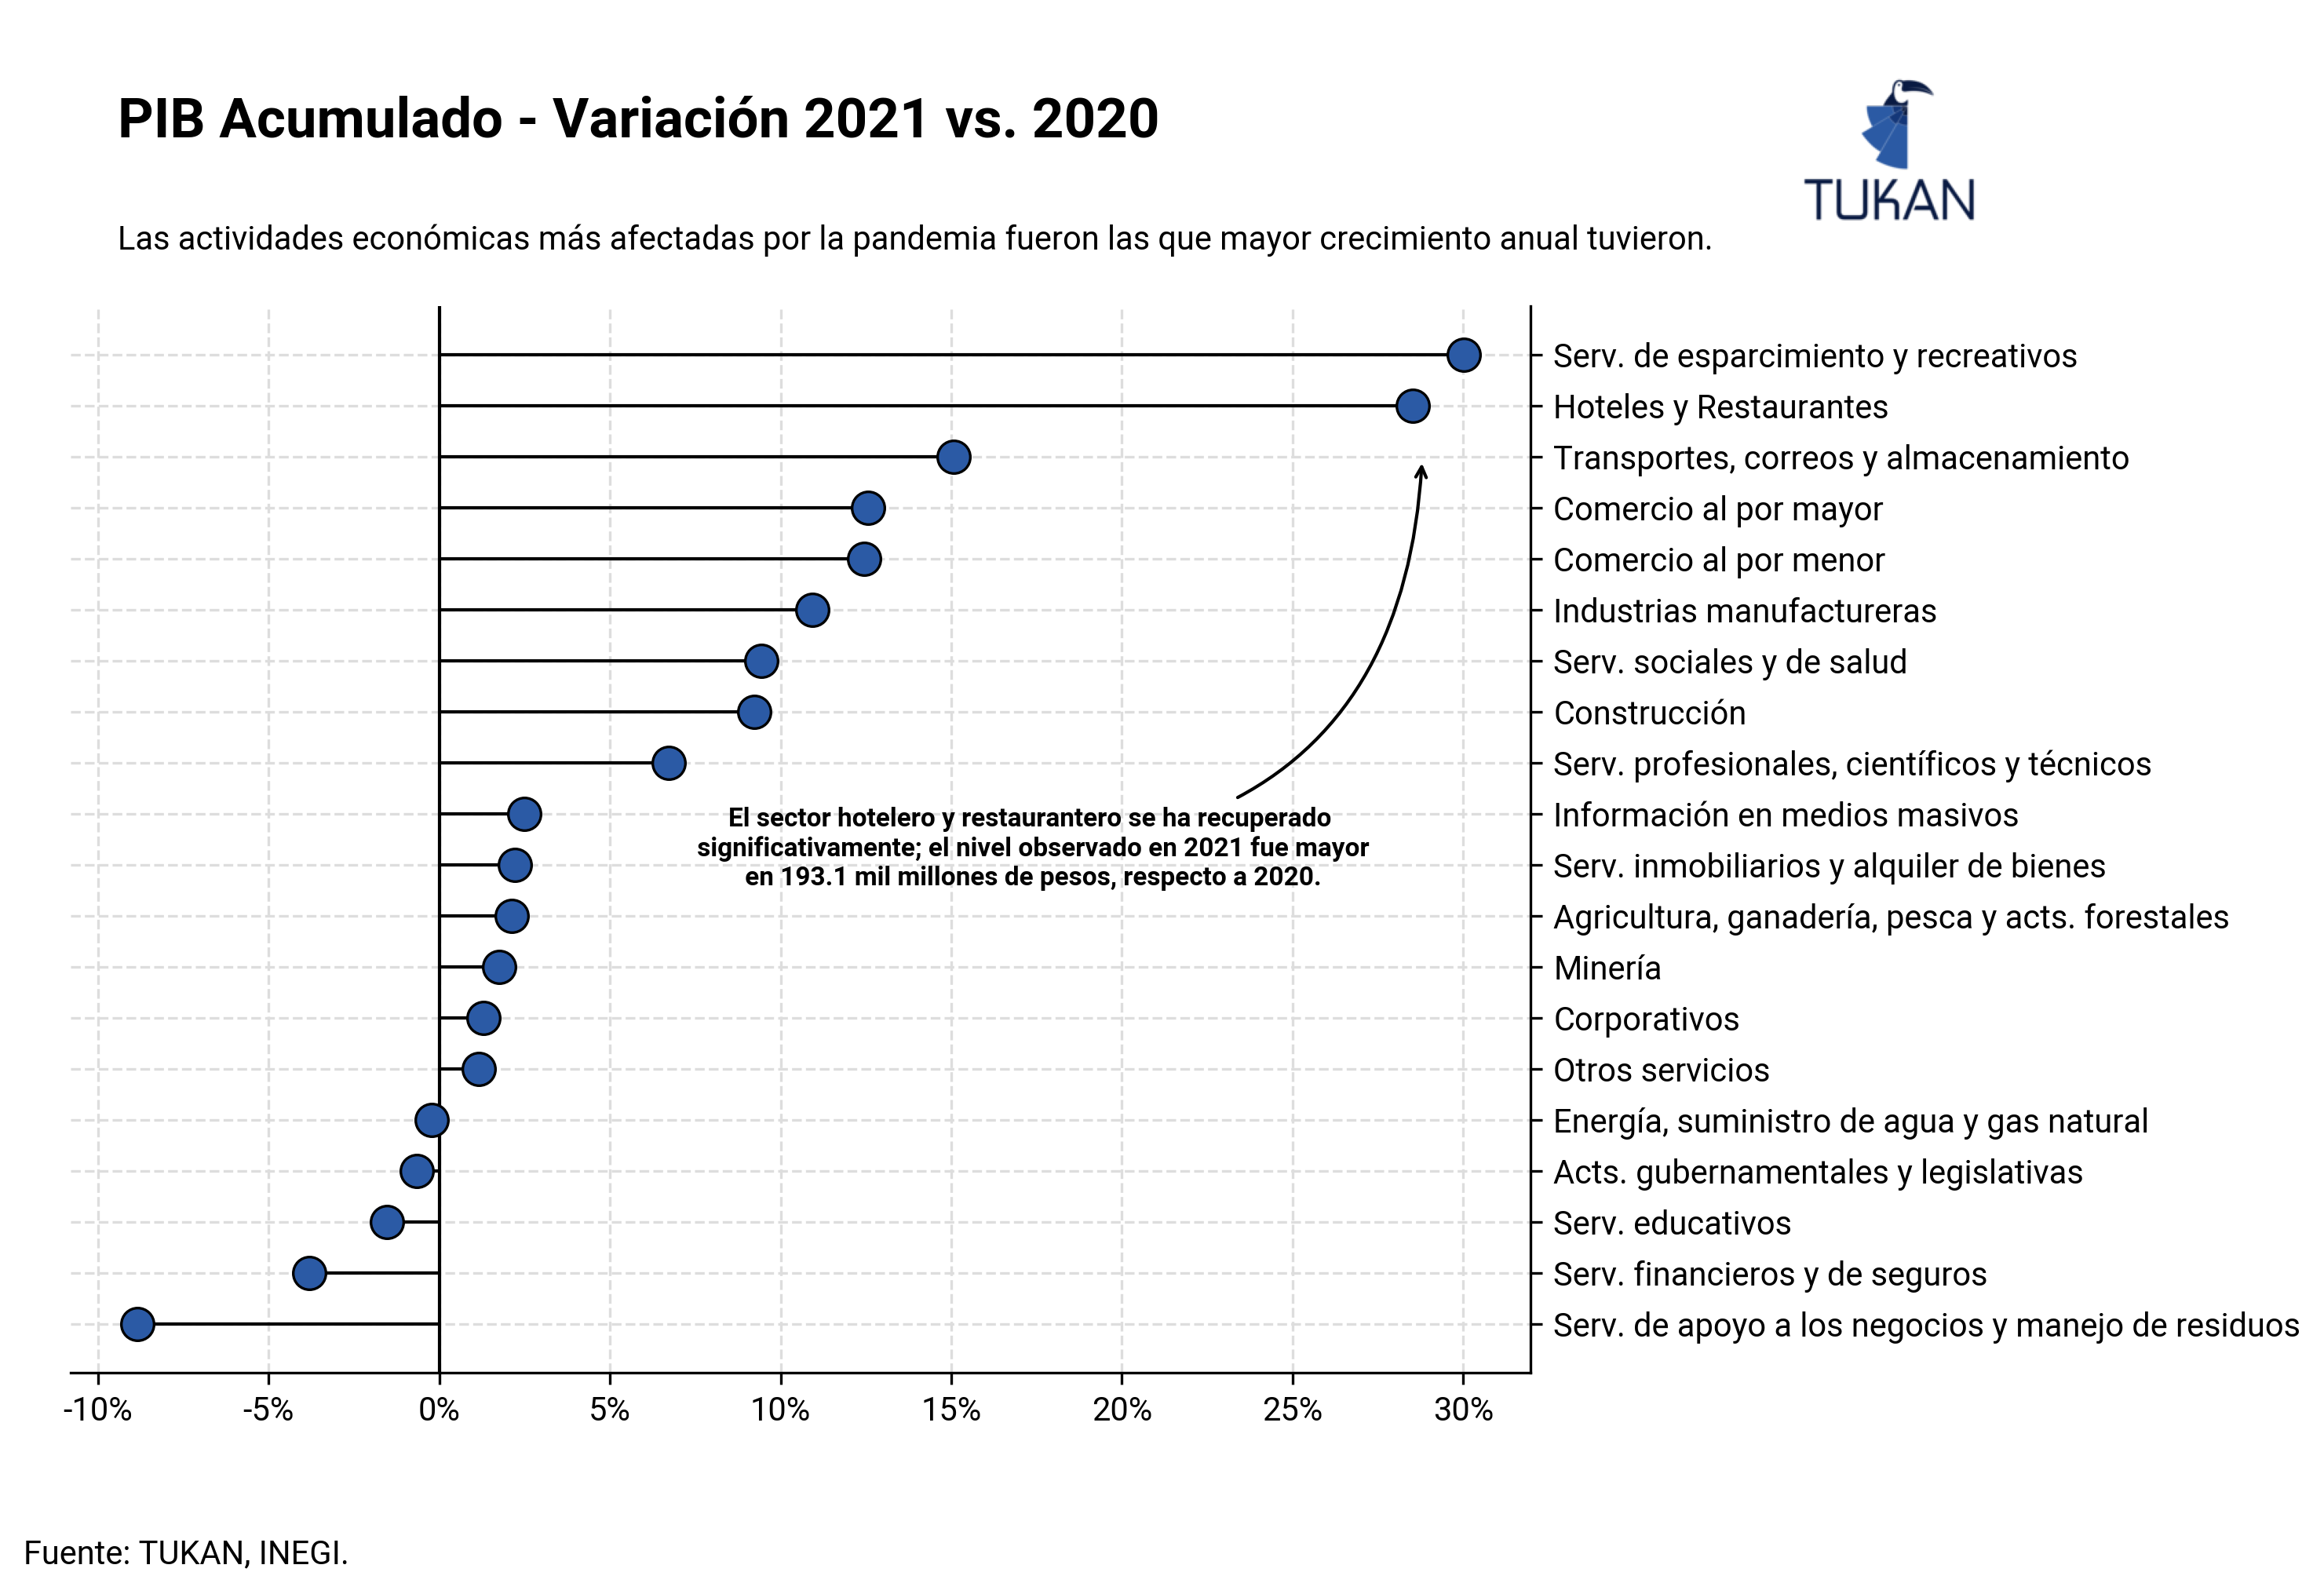

In [292]:

activities_gdp = activities_gdp.sort_values('var_2021_2020', ascending=True)
activities_gdp['p_ref'] =  range(activities_gdp.shape[0]) #plot_reference
activities_gdp.reset_index(drop=True, inplace=True)

text_annotation = activities_gdp[activities_gdp['economic_activity']=='Hoteles y Restaurantes']
text_annotation = (text_annotation[2021] - text_annotation[2020])/1000
text_annotation = text_annotation.round(1)

labels = activities_gdp['economic_activity'].tolist()

fig = plt.figure(figsize=(8,6), dpi = 300)
ax = plt.subplot(111)

# Change splines
ax.spines["right"].set_visible(True)
ax.spines["left"].set_visible(False)

# Data to plot
for x in activities_gdp.index:
    if activities_gdp['var_2021_2020'].loc[x]>=0:
        ax.hlines(y=activities_gdp['p_ref'].loc[x], xmin=0, xmax=activities_gdp['var_2021_2020'].loc[x],lw=1, color='black' ,zorder=2)
    else:
        ax.hlines(y=activities_gdp['p_ref'].loc[x], xmin=activities_gdp['var_2021_2020'].loc[x], xmax=0,lw=1, color='black' ,zorder=2)
        
ax.scatter(activities_gdp['var_2021_2020'],activities_gdp['p_ref'],s=100, edgecolors='black', lw=0.8, zorder=3, label='2021')



# Add gridlines and format to ticks 
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0%}'))
ax.axvline(x=0,lw=1, color='black')
ax.set_yticks(range(activities_gdp.shape[0]))
ax.set_yticklabels(labels)

# Axis ticks on right side
ax.yaxis.tick_right()

# Annotation aux
text_annotation = activities_gdp[activities_gdp['economic_activity']=='Hoteles y Restaurantes']
text_annotation = (text_annotation[2021] - text_annotation[2020])/1000
text_annotation = text_annotation.round(1)

ax.annotate(
    "El sector hotelero y restaurantero se ha recuperado\n significativamente; el nivel observado en 2021 fue mayor\n en "+ str(text_annotation.iloc[0])+ " mil millones de pesos, respecto a 2020.",
    xy=(.288,
        17),
    xycoords="data",
    xytext=(-120, -120),
    textcoords="offset points",
    color="black",
    size=8,
    va="center",
    ha="center",
    weight="bold",
    arrowprops=dict(
        arrowstyle="->", ec="black", connectionstyle="arc3,rad=.45"
    ),
)

# Add title and subtitle
fig.text(
    0.15,
    1,
    "PIB Acumulado - Variación 2021 vs. 2020",
    size=17,
    weight = "bold"
)

fig.text(
    0.15,
    0.92,
    "Las actividades económicas más afectadas por la pandemia fueron las que mayor crecimiento anual tuvieron.",
    size=10
)

# Add footer
fig.text(0.1, -0.01, "Fuente: TUKAN, INEGI.", fontsize=10)

# Save plot with TUKAN logo, transparent and white
# plt.savefig(
#     "plots/gdp_activities_yoy_no_logo.png",
#     dpi=300,
#     bbox_inches="tight",
#     # facecolor="white",
#     edgecolor="none",
#     transparent=True,
# )

#Tukey's Swag
tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([1, .9, 0.16, 0.18], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")

plt.savefig(
    "plots/gdp_activities_yoy_logo.png",
    dpi=300,
    bbox_inches="tight",
    # facecolor="white",
    edgecolor="none",
    transparent=True,
)

plt.savefig(
    "plots/gdp_activities_yoy_white_logo.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
    transparent=False,
)

### 2021 vs 2019 plot

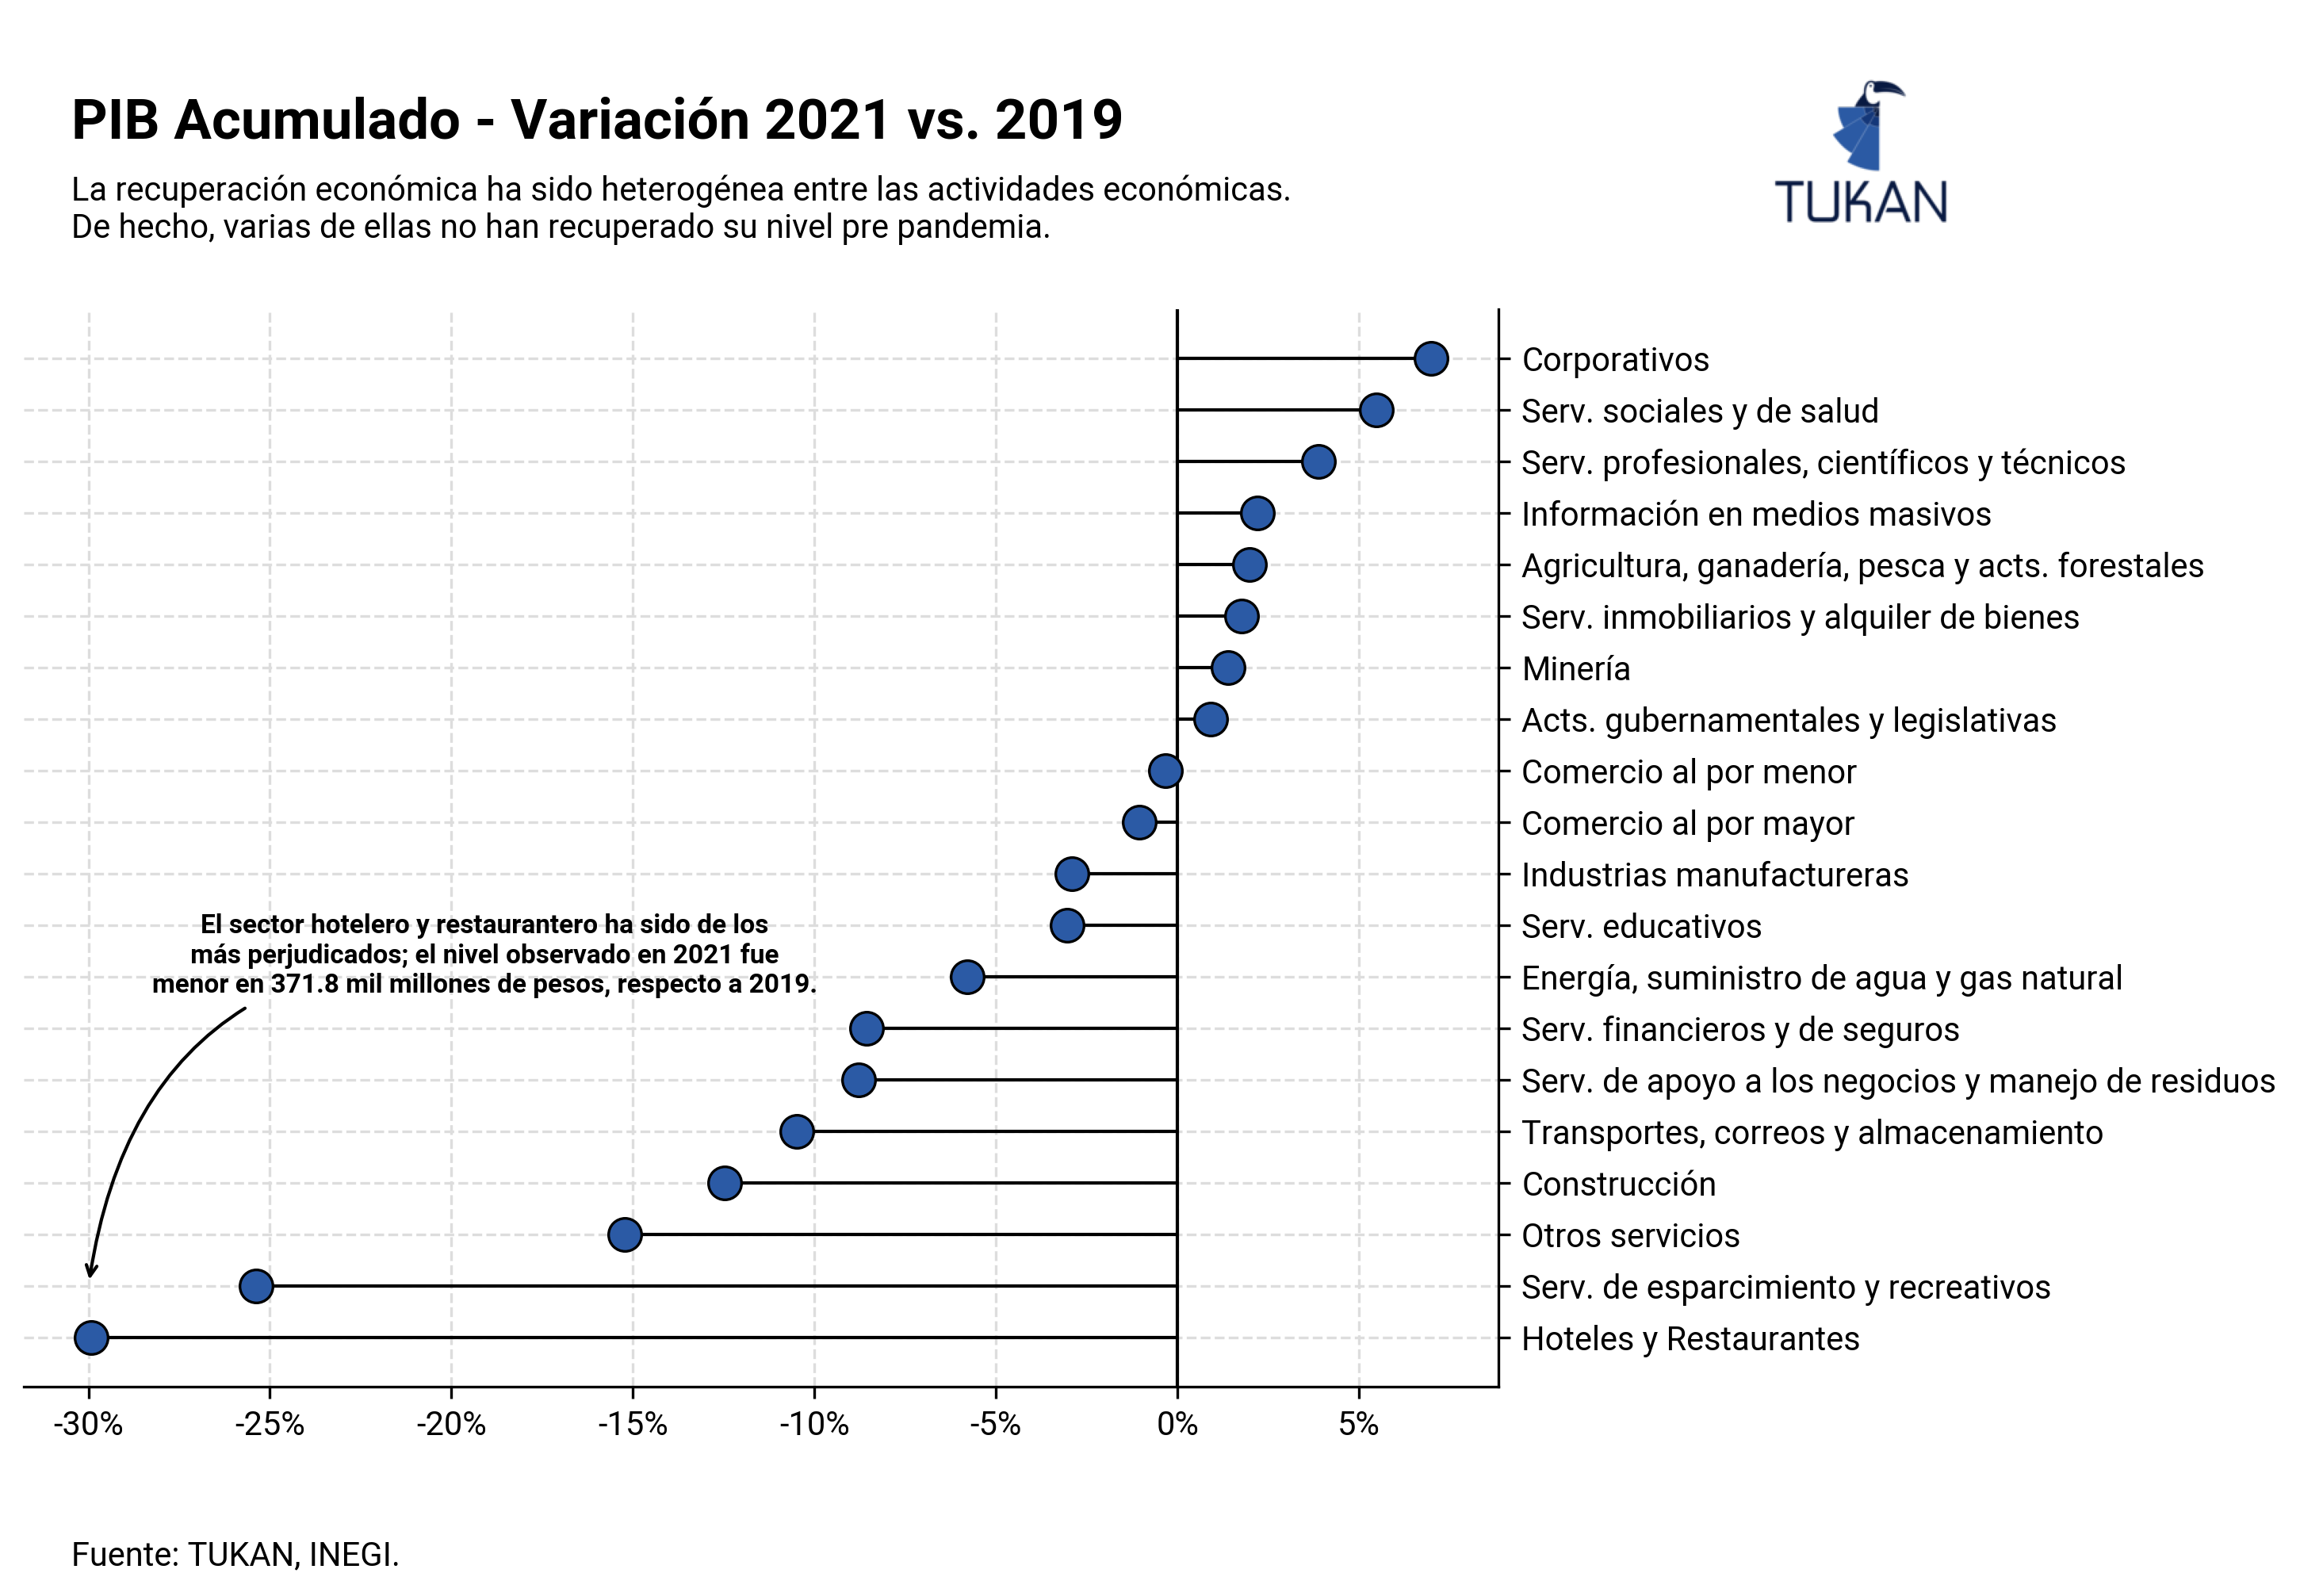

In [287]:
activities_gdp = activities_gdp.sort_values('var_2021_2019', ascending=True)
activities_gdp['p_ref'] =  range(activities_gdp.shape[0]) #plot_reference
activities_gdp.reset_index(drop=True, inplace=True)


labels = activities_gdp['economic_activity'].tolist()

fig = plt.figure(figsize=(8,6), dpi = 300)
ax = plt.subplot(111)

# Change splines
ax.spines["right"].set_visible(True)
ax.spines["left"].set_visible(False)

# Data to plot
for x in activities_gdp.index:
    if activities_gdp['var_2021_2019'].loc[x]>=0:
        ax.hlines(y=activities_gdp['p_ref'].loc[x], xmin=0, xmax=activities_gdp['var_2021_2019'].loc[x],lw=1, color='black' ,zorder=2)
    else:
        ax.hlines(y=activities_gdp['p_ref'].loc[x], xmin=activities_gdp['var_2021_2019'].loc[x], xmax=0,lw=1, color='black' ,zorder=2)

ax.scatter(activities_gdp['var_2021_2019'],activities_gdp['p_ref'],s=100, edgecolors='black', lw=0.8, zorder=3, label='2021')

# Add gridlines and format to ticks 
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0%}'))
ax.axvline(x=0,lw=1, color='black')
ax.set_yticks(range(activities_gdp.shape[0]))
ax.set_yticklabels(labels)

# Axis ticks on right side
ax.yaxis.tick_right()

# Annotation aux
text_annotation = activities_gdp[activities_gdp['economic_activity']=='Hoteles y Restaurantes']
text_annotation = (text_annotation[2021] - text_annotation[2019])/1000
text_annotation = text_annotation.round(1)

ax.annotate(
    "El sector hotelero y restaurantero ha sido de los\n más perjudicados; el nivel observado en 2021 fue \nmenor en "+ str(abs(text_annotation.iloc[0]))+ " mil millones de pesos, respecto a 2019.",
    xy=(-.3,
        1),
    xycoords="data",
    xytext=(120, 100),
    textcoords="offset points",
    color="black",
    size=8,
    va="center",
    ha="center",
    weight="bold",
    arrowprops=dict(
        arrowstyle="->", ec="black", connectionstyle="arc3,rad=.45"
    ),
)

# Add title and subtitle
fig.text(
    0.15,
    1,
    "PIB Acumulado - Variación 2021 vs. 2019",
    size=17,
    weight = "bold"
)

fig.text(
    0.15,
    0.93,
    "La recuperación económica ha sido heterogénea entre las actividades económicas.\nDe hecho, varias de ellas no han recuperado su nivel pre pandemia.",
    size=10
)

# Add footer
fig.text(0.15, -0, "Fuente: TUKAN, INEGI.", fontsize=10)

# Save plot with TUKAN logo, transparent and white
# plt.savefig(
#     "plots/gdp_activities_pandemic_no_logo.png",
#     dpi=300,
#     bbox_inches="tight",
#     # facecolor="white",
#     edgecolor="none",
#     transparent=True,
# )

#Tukey's Swag
tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([1, .9, 0.16, 0.18], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")

plt.savefig(
    "plots/gdp_activities_pandemic_logo.png",
    dpi=300,
    bbox_inches="tight",
    # facecolor="white",
    edgecolor="none",
    transparent=True,
)

plt.savefig(
    "plots/gdp_activities_pandemic_white_logo.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
    transparent=False,
)